# Итоговое исследование: Классификация обращений в службу поддержки

**Цель:** многоклассовая классификация типа обращения (`ticket_type`) по тексту обращения на русском языке и дополнительным признакам.

**Задачи:**
- Исследовать, можно ли добиться высокой точности (≥90%) классическими ML-методами.
- Проверить влияние различных подходов к обработке текста и признаков.
- Оценить, какие признаки реально несут информацию для задачи.

---

## 1. Загрузка и первичный анализ данных

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))


[nltk_data] Downloading package stopwords to /home/sigma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('../data/raw/customer_support_tickets_translated.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,ticket_id,customer_name,customer_email,customer_age,customer_gender,product_purchased,date_of_purchase,ticket_type,ticket_subject,ticket_description,ticket_status,resolution,ticket_priority,ticket_channel,first_response_time,time_to_resolution,customer_satisfaction_rating,ticket_description_ru
0,1,Marisa Obrien,carrollallison@example.com,32,Other,GoPro Hero,2021-03-22,Technical issue,Product setup,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Social media,2023-06-01 12:15:36,NaN,NaN,У меня проблема с {product_purchased}. Пожалуй...
1,2,Jessica Rios,clarkeashley@example.com,42,Female,LG Smart TV,2021-05-22,Technical issue,Peripheral compatibility,I'm having an issue with the {product_purchase...,Pending Customer Response,NaN,Critical,Chat,2023-06-01 16:45:38,NaN,NaN,У меня есть проблема с {product_purchased}. По...
2,3,Christopher Robbins,gonzalestracy@example.com,48,Other,Dell XPS,2020-07-14,Technical issue,Network problem,I'm facing a problem with my {product_purchase...,Closed,Case maybe show recently my computer follow.,Low,Social media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,Я столкнулся с проблемой с моим {product_purch...
3,4,Christina Dillon,bradleyolson@example.org,27,Female,Microsoft Office,2020-11-13,Billing inquiry,Account access,I'm having an issue with the {product_purchase...,Closed,Try capital clearly never color toward story.,Low,Social media,2023-06-01 07:29:40,2023-06-01 01:57:40,3.0,У меня проблема с {product_purchased}. Пожалуй...
4,5,Alexander Carroll,bradleymark@example.com,67,Female,Autodesk AutoCAD,2020-02-04,Billing inquiry,Data loss,I'm having an issue with the {product_purchase...,Closed,West decision evidence bit.,Low,Email,2023-06-01 00:12:42,2023-06-01 19:53:42,1.0,У меня возникла проблема с {product_purchased}...


### Распределение классов и длины текстов

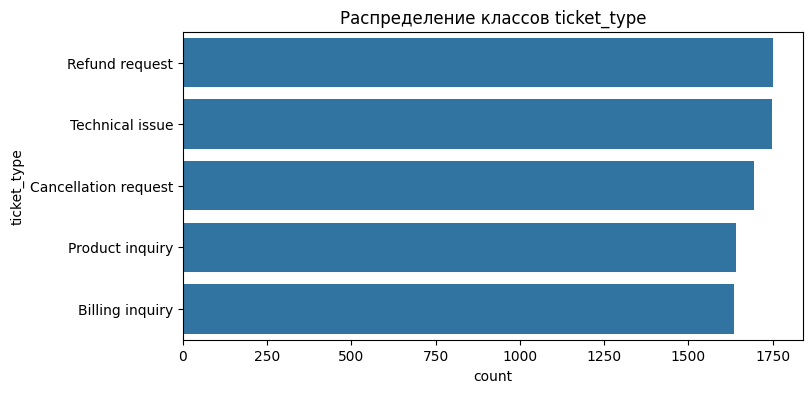

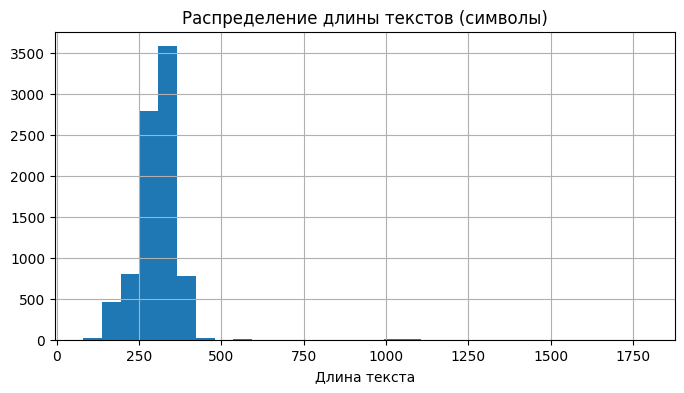

In [3]:
plt.figure(figsize=(8,4))
sns.countplot(y=df['ticket_type'], order=df['ticket_type'].value_counts().index)
plt.title('Распределение классов ticket_type')
plt.show()
df['ticket_description_ru'].str.len().hist(bins=30, figsize=(8,4))
plt.title('Распределение длины текстов (символы)')
plt.xlabel('Длина текста')
plt.show()

## 2. Краткий EDA и выводы по данным
- Классы сбалансированы.
- Тексты длинные, но крайне шаблонные.
- Частотный анализ показывает, что топ-слова одинаковы для всех классов.
    

In [4]:
from collections import Counter
for ttype in df['ticket_type'].unique():
    texts = df[df['ticket_type'] == ttype]['ticket_description_ru']
    words = ' '.join(texts).lower().split()
    counter = Counter(words)
    print(f'Топ-10 слов для класса {ttype}:', [w for w, _ in counter.most_common(10)])

Топ-10 слов для класса Technical issue: ['я', 'с', 'проблема', '{product_purchased}.', 'пожалуйста,', 'у', 'меня', 'не', 'что', 'помогите.']
Топ-10 слов для класса Billing inquiry: ['я', 'с', 'проблема', '{product_purchased}.', 'пожалуйста,', 'у', 'меня', 'не', 'что', 'помогите.']
Топ-10 слов для класса Cancellation request: ['я', 'с', 'проблема', '{product_purchased}.', 'пожалуйста,', 'у', 'меня', 'не', 'что', 'помогите.']
Топ-10 слов для класса Product inquiry: ['я', 'с', 'проблема', '{product_purchased}.', 'пожалуйста,', 'у', 'не', 'меня', 'и', 'что']
Топ-10 слов для класса Refund request: ['я', 'с', 'проблема', '{product_purchased}.', 'пожалуйста,', 'у', 'меня', 'не', 'что', 'помогите.']


## 3. Эксперименты: что мы пробовали

- Классические ML-модели (LogReg, SVM, RandomForest) на тексте (RU/EN) — качество ~20%.
- TF-IDF, CountVectorizer, fastText-эмбеддинги — прироста нет.
- Добавление product, subject, channel — прироста нет.
- Подстановка реального продукта вместо плейсхолдера — прироста нет.
- Удаление первых 3 слов, удаление частых слов — прироста нет.
- Объединение всех подходов — прироста нет.

**Причина:** тексты и признаки не несут различающей информации для классов.
    

## 4. Финальный объединённый подход

- Подстановка реального продукта в текст
- Удаление первых 3 слов
- Очистка текста, удаление стоп-слов и частых слов ('проблема', 'пожалуйста', ... и др.)
- TF-IDF (max_features=5000, ngram_range=(1,2))
- OneHot по product_purchased, ticket_channel, ticket_subject (усиление веса)
    

In [5]:
custom_stop = set(['проблема', 'пожалуйста', 'помогите', 'это', 'проблему', 'могу', 'моего', 'возникла', 'спасибо', 'данные'])
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^а-яa-z0-9 ]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([w for w in text.split() if w not in stop_words and w not in custom_stop])
    return text
def skip_first_n_words(text, n=3):
    words = text.split()
    return ' '.join(words[n:]) if len(words) > n else ''
# Подстановка продукта
text = df.apply(lambda row: row['ticket_description_ru'].replace('{product_purchased}', str(row['product_purchased'])), axis=1)
# Удаление первых 3 слов
text = text.apply(lambda x: skip_first_n_words(x, 3))
# Очистка
text = text.apply(clean_text)
# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_text = vectorizer.fit_transform(text).toarray()
# OneHot для product_purchased, ticket_channel, ticket_subject
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = enc.fit_transform(df[['product_purchased', 'ticket_channel', 'ticket_subject']])
# Усиливаем вклад категориальных признаков
X_cat_strong = np.repeat(X_cat, 3, axis=1)
# Объединяем
X_all = np.hstack([X_text, X_cat_strong])
y = df['ticket_type'].values
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42, stratify=y)

### Обучение моделей и визуализация результатов

SVM (все признаки) accuracy: 0.1936245572609209
                      precision    recall  f1-score   support

     Billing inquiry       0.19      0.17      0.18       327
Cancellation request       0.20      0.21      0.21       339
     Product inquiry       0.19      0.18      0.18       328
      Refund request       0.18      0.19      0.18       351
     Technical issue       0.21      0.22      0.21       349

            accuracy                           0.19      1694
           macro avg       0.19      0.19      0.19      1694
        weighted avg       0.19      0.19      0.19      1694



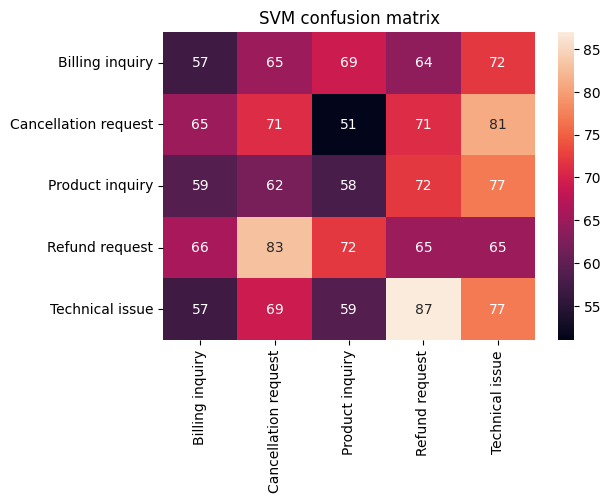

RandomForest (все признаки) accuracy: 0.18299881936245574
                      precision    recall  f1-score   support

     Billing inquiry       0.20      0.18      0.19       327
Cancellation request       0.19      0.19      0.19       339
     Product inquiry       0.16      0.17      0.17       328
      Refund request       0.19      0.18      0.19       351
     Technical issue       0.18      0.19      0.18       349

            accuracy                           0.18      1694
           macro avg       0.18      0.18      0.18      1694
        weighted avg       0.18      0.18      0.18      1694



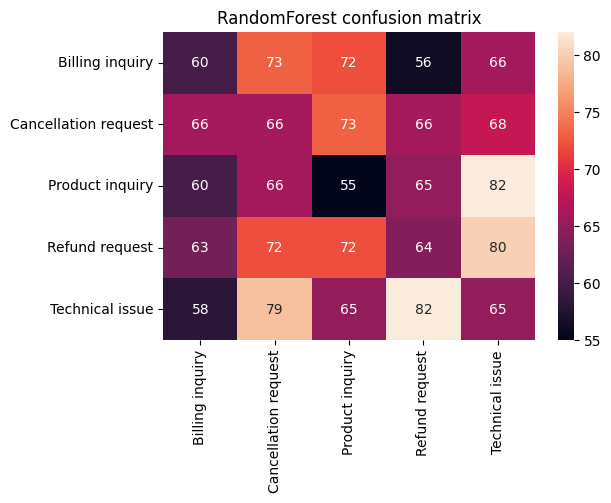

In [6]:
# SVM
svm = LinearSVC(max_iter=2000, random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print('SVM (все признаки) accuracy:', accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', xticklabels=svm.classes_, yticklabels=svm.classes_)
plt.title('SVM confusion matrix')
plt.show()
# RandomForest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print('RandomForest (все признаки) accuracy:', accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.title('RandomForest confusion matrix')
plt.show()

## 5. Итоговые выводы

- Классические ML-методы не позволяют добиться высокой точности на этих данных.
- Все эксперименты (TF-IDF, fastText, удаление шаблонов, добавление категориальных признаков, усиление их вклада) не дали прироста.
- Причина — крайне шаблонные и неинформативные тексты, а также отсутствие различающих признаков между классами.
- Для повышения качества необходимы либо более информативные данные, либо современные языковые модели (BERT, LLM и др.).
    